<a href="https://colab.research.google.com/github/Hubert26/suicides_IPPAN/blob/main/suicides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Liblaries and settings

In [408]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

#Ustawienie braku maksymalnej ilości wyświetlanych kolumn
pd.options.display.max_columns = None

np.random.seed(42)

#Function definitions

In [409]:
def display_info(df, selected_columns):
    print(selected_columns)
    print(len(selected_columns))
    for col_name in selected_columns:

        # Mode
        print("\nMode:")
        print(df[col_name].mode())

        # NaN count
        nan_count = df[col_name].isna().sum()
        print("\nNaN count:", nan_count)

        # Unique values len
        print("\nUnique values len:")
        print(len(df[col_name].unique()))

        # Unique values
        print("\nUnique values:")
        print(df[col_name].unique())

        # Value counts
        print("\nValue counts:")
        print(df[col_name].value_counts())

        print("\n" + "=" * 40)  # Separator between columns


In [410]:
def create_bar_plot(x_values, y_values, x_label, y_label, title, x_rotation=0):

    # Tworzenie wykresu słupkowego
    plt.bar(x_values, y_values)

    # Dodanie wartości nad słupkami
    for i in range(len(x_values)):
        plt.text(x_values[i], y_values[i], str(y_values[i]), ha='center', va='bottom')

    # Dodanie tytułu i etykiet osi
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Wyświetlenie wykresu
    plt.xticks(rotation=x_rotation, ha='right')
    plt.tight_layout()
    plt.show()


In [411]:
def create_double_bar_plot(x_values, y_values1, y_values2, x_label, y_label, title, x_rotation=0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # Tworzenie dwóch subplotów obok siebie

    # Utworzenie słupków dla obu serii danych
    bars1 = ax1.bar(x_values, y_values1, label='Series 1')
    bars2 = ax2.bar(x_values, y_values2, label='Series 2')

    # Dodanie wartości nad słupkami dla serii 1
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Dodanie wartości nad słupkami dla serii 2
    for bar in bars2:
        height = bar.get_height()
        ax2.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Dodanie tytułów i etykiet osi
    ax1.set_title(title)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')

    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)
    ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')

    # Wyświetlenie wykresu
    plt.tight_layout()
    plt.show()

#Data exploration

In [412]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/Hubert26/suicides_IPPAN/main/data/df_data.csv', delimiter=',', low_memory=False)

In [413]:
df_raw.head()

,suicide_id,report_date_year,report_date_month,age_group,gender,marital_status,education,work_study_info,livelihood_source,is_fatal,location_of_attack,method_of_committing,consciousness_state,substance_info,treatment_info,"reasons_of_attack_Bullying, cyberbullying, harassment",reasons_of_attack_Chronic illness,reasons_of_attack_Committing a crime or misdemeanor,reasons_of_attack_Conflict with non-family members,reasons_of_attack_Death of a close person,reasons_of_attack_Deterioration or sudden loss of health,reasons_of_attack_Family misunderstanding/family violence,"reasons_of_attack_HIV carrier, AIDS patient",reasons_of_attack_Love affair,reasons_of_attack_Mental illness/mental disorders,reasons_of_attack_Other unspecified,reasons_of_attack_Permanent disability,reasons_of_attack_Physical illness,reasons_of_attack_Poor economic conditions/debt,reasons_of_attack_School or work problems,reasons_of_attack_Sudden loss of livelihood,reasons_of_attack_Threat or loss of housing,reasons_of_attack_Unwanted pregnancy,reason_of_attack_count
0,114 581 552,2013,1,NaN,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,114 584 284,2013,1,13-18,male,NaN,NaN,Student,NaN,1.0,Road/street/sidewalk,Throwing oneself under a moving vehicle,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,114 584 293,2013,1,13-18,female,Single,Primary education,Student,Dependent on another person,1.0,Other,Jumping from a height,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,114 584 312,2013,1,19-24,male,Single,NaN,NaN,NaN,1.0,NaN,Other,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,114 584 399,2013,1,40-44,male,Single,NaN,Unemployed,NaN,1.0,Outbuildings,Hanging,Under the influence of alcohol,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [414]:
selected_columns = [
    'reasons_of_attack_Bullying, cyberbullying, harassment',
    'reasons_of_attack_Chronic illness',
    'reasons_of_attack_Committing a crime or misdemeanor',
    'reasons_of_attack_Conflict with non-family members',
    'reasons_of_attack_Death of a close person',
    'reasons_of_attack_Deterioration or sudden loss of health',
    'reasons_of_attack_Family misunderstanding/family violence',
    'reasons_of_attack_HIV carrier, AIDS patient',
    'reasons_of_attack_Love affair',
    'reasons_of_attack_Mental illness/mental disorders',
    'reasons_of_attack_Other unspecified',
    'reasons_of_attack_Permanent disability',
    'reasons_of_attack_Physical illness',
    'reasons_of_attack_Poor economic conditions/debt',
    'reasons_of_attack_School or work problems',
    'reasons_of_attack_Sudden loss of livelihood',
    'reasons_of_attack_Threat or loss of housing',
    'reasons_of_attack_Unwanted pregnancy'
]

df_data = df_raw.drop(columns=selected_columns)
df_data_reasons_of_attack = df_raw[selected_columns]

In [415]:
df_data['reason_of_attack_count'] = df_data['reason_of_attack_count'].replace(0, np.nan)

##NaN exploration in variables

In [416]:
df_data.shape

(113196, 16)

In [417]:
df_data[df_data['suicide_id'].duplicated()].suicide_id #Sprawdzenie duplikatów

Series([], Name: suicide_id, dtype: object)

In [418]:
##Brakujące dane
total = df_data.isnull().sum().sort_values(ascending=False)
percent = 100*(df_data.isnull().sum()/df_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [419]:
missing_data

,Total,Percent
treatment_info,108281,95.657974
substance_info,93753,82.823598
education,77929,68.844305
consciousness_state,58827,51.969151
work_study_info,55930,49.409873
livelihood_source,49338,43.586346
reason_of_attack_count,40058,35.388176
marital_status,14345,12.672709
age_group,1288,1.137849
location_of_attack,106,0.093643


##NaN exploration in rows

In [420]:
nan_counts = df_data.isna().sum(axis=1).value_counts()

In [421]:
full_index = list(range(0, len(df_data.columns.tolist()) + 1))

# Zsumowanie istniejących wartości z pełną listą i ustawienie brakujących wartości na 0
nan_counts = nan_counts.reindex(full_index, fill_value=0)

# Sortowanie wyników rosnąco
nan_counts = nan_counts.sort_index()

In [422]:
nan_counts_proc = (nan_counts / len(df_data)) * 100

In [423]:
missing_data_rows = pd.concat([nan_counts, nan_counts_proc], axis=1, keys=['Total', 'Percent'])
missing_data_rows

,Total,Percent
0,83,0.073324
1,3873,3.421499
2,15283,13.501360
3,19126,16.896357
4,19919,17.596912
5,21450,18.949433
6,17743,15.674582
7,11497,10.156719
8,3882,3.429450
9,263,0.232340


In [424]:
# Usunięcie wierszy z df_data i df_data_reasons_of_attack gdzie są NaN w 'gender' i 'age_group'
selected_index = df_data[df_data['gender'].isna() | df_data['age_group'].isna()].index

df_data = df_data.drop(index=selected_index)
df_data_reasons_of_attack = df_data_reasons_of_attack.drop(index=selected_index)

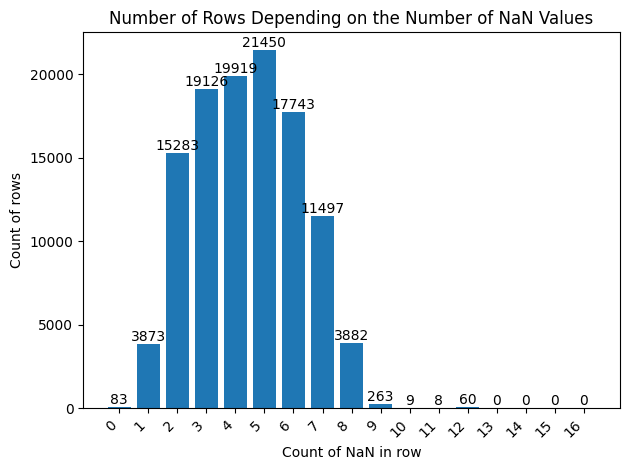

In [425]:
create_bar_plot(
                nan_counts.reset_index().iloc[:, 0].astype(str).tolist(),
                nan_counts.reset_index().iloc[:, 1].tolist(),
                'Count of NaN in row',
                'Count of rows',
                'Number of Rows Depending on the Number of NaN Values',
                x_rotation=45)

##data_age_groups

In [426]:
sorted(list(set(df_data['age_group'])))


['13-18',
 '19-24',
 '25-29',
 '30-34',
 '35-39',
 '40-44',
 '45-49',
 '50-54',
 '55-59',
 '60-64',
 '65-69',
 '7-12',
 '70-74',
 '75-79',
 '80-84',
 '85+']

###data_age_group_7-12

In [427]:
age_group = '7-12'

In [428]:
selected_index = df_data.loc[df_data['age_group'] == age_group].index

In [429]:
data_age_group = df_data.loc[selected_index]
data_age_group_reasons_of_attack = df_data_reasons_of_attack.loc[selected_index]

In [430]:
data_age_group.shape

(343, 16)

In [431]:
female_index = data_age_group.loc[data_age_group['gender'] == 'female'].index

In [432]:
male_index = data_age_group.loc[data_age_group['gender'] == 'male'].index

####NaN exploration in variables

In [433]:
##Brakujące dane
total = data_age_group.isnull().sum().sort_values(ascending=False)
percent = 100*(data_age_group.isnull().sum()/data_age_group.isnull().count()).sort_values(ascending=False)
missing_data_age_group = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [434]:
missing_data_age_group

,Total,Percent
substance_info,343,100.000000
treatment_info,343,100.000000
consciousness_state,120,34.985423
reason_of_attack_count,85,24.781341
education,44,12.827988
livelihood_source,17,4.956268
work_study_info,12,3.498542
marital_status,6,1.749271
suicide_id,0,0.000000
report_date_year,0,0.000000


####NaN exploration in rows

In [435]:
nan_counts = data_age_group.isna().sum(axis=1).value_counts()

In [436]:
full_index = list(range(0, len(data_age_group.columns.tolist()) + 1))

# Zsumowanie istniejących wartości z pełną listą i ustawienie brakujących wartości na 0
nan_counts = nan_counts.reindex(full_index, fill_value=0)

# Sortowanie wyników rosnąco
nan_counts = nan_counts.sort_index()

In [437]:
nan_counts_proc = (nan_counts / len(data_age_group)) * 100

In [438]:
missing_data_rows = pd.concat([nan_counts, nan_counts_proc], axis=1, keys=['Total', 'Percent'])
missing_data_rows

,Total,Percent
0,0,0.000000
1,0,0.000000
2,158,46.064140
3,116,33.819242
4,46,13.411079
5,17,4.956268
6,5,1.457726
7,1,0.291545
8,0,0.000000
9,0,0.000000


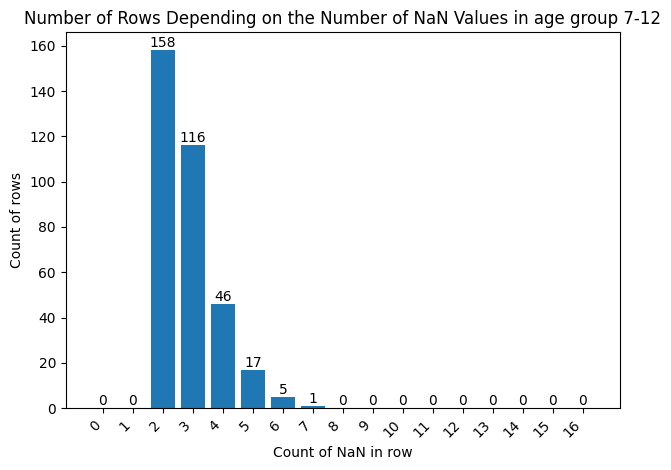

In [439]:
create_bar_plot(
                nan_counts.reset_index().iloc[:, 0].astype(str).tolist(),
                nan_counts.reset_index().iloc[:, 1].tolist(),
                'Count of NaN in row',
                'Count of rows',
                'Number of Rows Depending on the Number of NaN Values' + ' in age group ' + age_group,
                x_rotation=45)

In [440]:
# data_age_group = data_age_group[data_age_group_7_12.isna().sum(axis=1) <= 8]

####Variable - consciousness_state

In [441]:
variable = 'consciousness_state'

In [442]:
display_info(data_age_group, [variable])

['consciousness_state']
1

Mode:
0    Sober
Name: consciousness_state, dtype: object

NaN count: 120

Unique values len:
8

Unique values:
['Under the influence of alcohol' 'Sober' nan
 'Under the influence of psychotropic substances (drugs, etc.)'
 'Under the influence of substitute substances (legal highs)'
 'Under the influence of medications' 'Under the influence of intoxicants'
 'Under the influence of alcohol and medications']

Value counts:
Sober                                                           166
Under the influence of medications                               45
Under the influence of alcohol                                    6
Under the influence of intoxicants                                3
Under the influence of psychotropic substances (drugs, etc.)      1
Under the influence of substitute substances (legal highs)        1
Under the influence of alcohol and medications                    1
Name: consciousness_state, dtype: int64



In [443]:
serie_values = data_age_group[variable].dropna().value_counts().values.tolist()

In [444]:
serie_indexes = data_age_group[variable].dropna().value_counts().index.tolist()

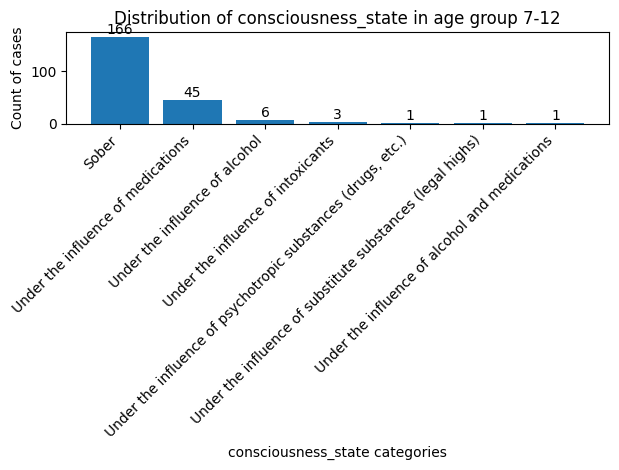

In [445]:
create_bar_plot(
                serie_indexes,
                serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####female

In [446]:
female_serie_indexes = data_age_group.loc[female_index, variable].dropna().value_counts().index.tolist()

In [447]:
female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

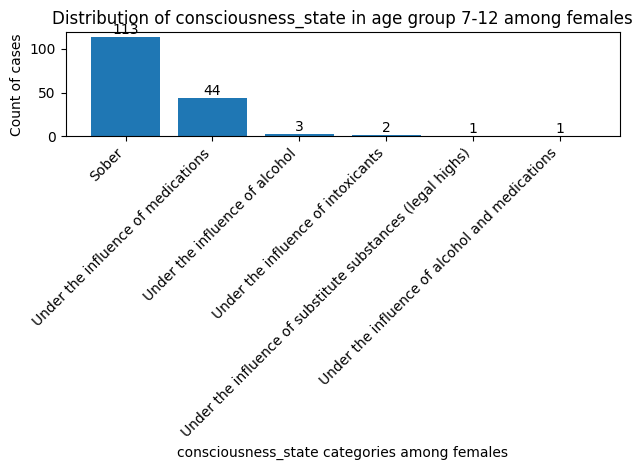

In [448]:
create_bar_plot(
                female_serie_indexes,
                female_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [449]:
female_probabilities = [x / sum(female_serie_values) for x in female_serie_values]

In [450]:
female_null_index = female_index[data_age_group.loc[female_index, variable].isnull()]


In [451]:
data_age_group.loc[female_null_index, variable] = np.random.choice(female_serie_indexes, size=len(female_null_index.tolist()), p=female_probabilities)

#####male

In [452]:
male_serie_indexes = data_age_group.loc[male_index, variable].dropna().value_counts().index.tolist()

In [453]:
male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

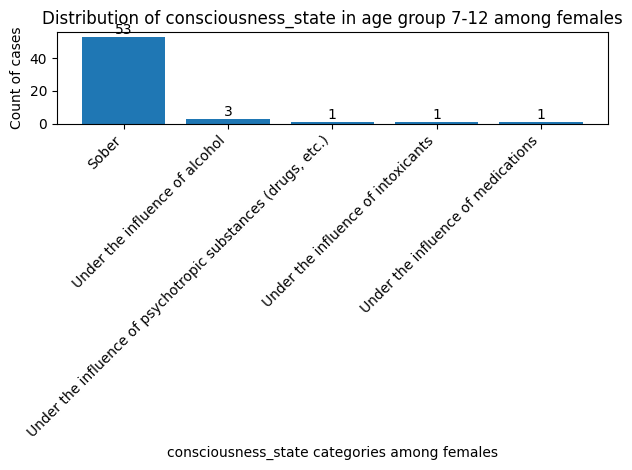

In [454]:
create_bar_plot(
                male_serie_indexes,
                male_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [455]:
male_probabilities = [x / sum(male_serie_values) for x in male_serie_values]

In [456]:
male_null_index = male_index[data_age_group.loc[male_index, variable].isnull()]


In [457]:
data_age_group.loc[male_null_index, variable] = np.random.choice(male_serie_indexes, size=len(male_null_index.tolist()), p=male_probabilities)

##### Summary

In [458]:
new_female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

<ipython-input-411-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-411-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


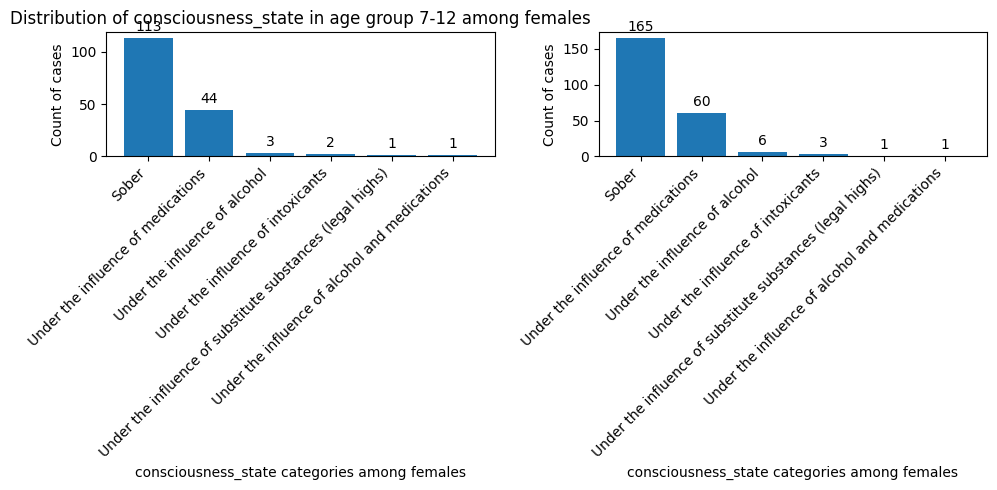

In [459]:
create_double_bar_plot(
                      female_serie_indexes,
                      female_serie_values,
                      new_female_serie_values,
                      variable + ' categories' + ' among females',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                      x_rotation=45)

In [460]:
new_male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

<ipython-input-411-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-411-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


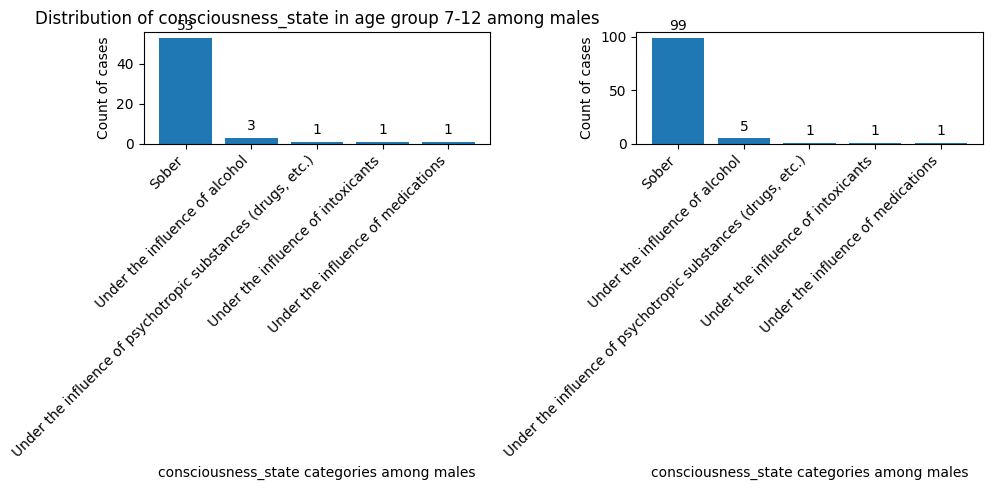

In [461]:
create_double_bar_plot(
                      male_serie_indexes,
                      male_serie_values,
                      new_male_serie_values,
                      variable + ' categories' + ' among males',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                      x_rotation=45)

In [462]:
new_serie_values = data_age_group[variable].value_counts().values.tolist()

<ipython-input-411-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-411-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


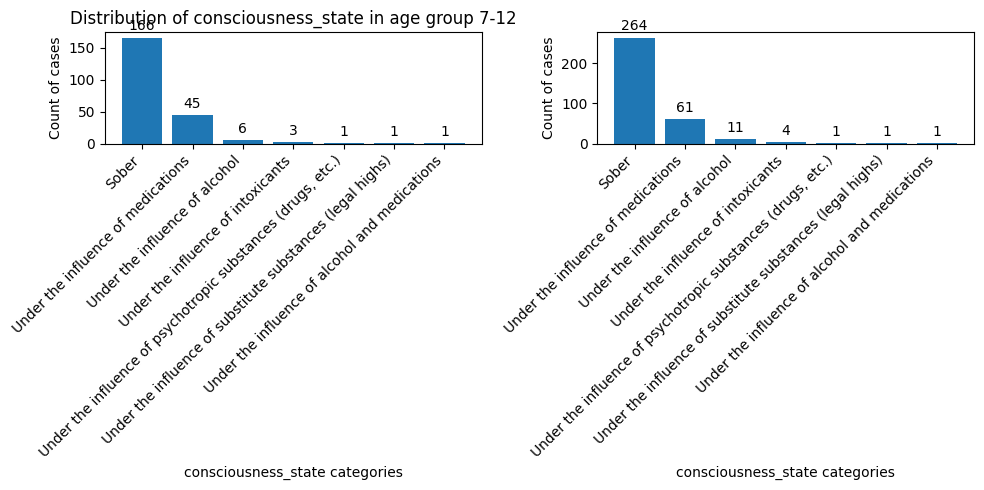

In [463]:
create_double_bar_plot(
                serie_indexes,
                serie_values,
                new_serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

####Variable - education

In [ ]:
variable = ''

In [ ]:
display_info(data_age_group, [variable])

['consciousness_state']
1

Mode:
0    Sober
Name: consciousness_state, dtype: object

NaN count: 120

Unique values len:
8

Unique values:
['Under the influence of alcohol' 'Sober' nan
 'Under the influence of psychotropic substances (drugs, etc.)'
 'Under the influence of substitute substances (legal highs)'
 'Under the influence of medications' 'Under the influence of intoxicants'
 'Under the influence of alcohol and medications']

Value counts:
Sober                                                           166
Under the influence of medications                               45
Under the influence of alcohol                                    6
Under the influence of intoxicants                                3
Under the influence of psychotropic substances (drugs, etc.)      1
Under the influence of substitute substances (legal highs)        1
Under the influence of alcohol and medications                    1
Name: consciousness_state, dtype: int64



In [ ]:
serie_values = data_age_group[variable].dropna().value_counts().values.tolist()

In [ ]:
serie_indexes = data_age_group[variable].dropna().value_counts().index.tolist()

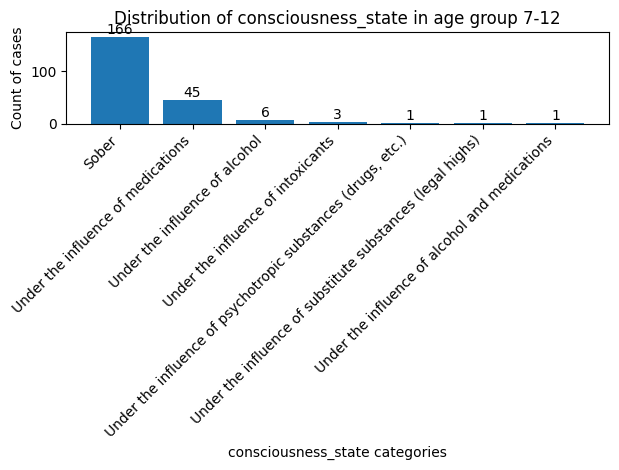

In [ ]:
create_bar_plot(
                serie_indexes,
                serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####female

In [ ]:
female_serie_indexes = data_age_group.loc[female_index, variable].dropna().value_counts().index.tolist()

In [ ]:
female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

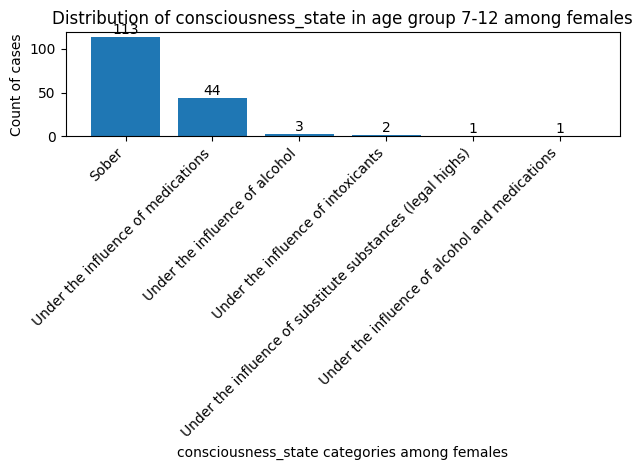

In [ ]:
create_bar_plot(
                female_serie_indexes,
                female_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [ ]:
female_probabilities = [x / sum(female_serie_values) for x in female_serie_values]

In [ ]:
female_null_index = female_index[data_age_group.loc[female_index, variable].isnull()]


In [ ]:
data_age_group.loc[female_null_index, variable] = np.random.choice(female_serie_indexes, size=len(female_null_index.tolist()), p=female_probabilities)

#####male

In [ ]:
male_serie_indexes = data_age_group.loc[male_index, variable].dropna().value_counts().index.tolist()

In [ ]:
male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

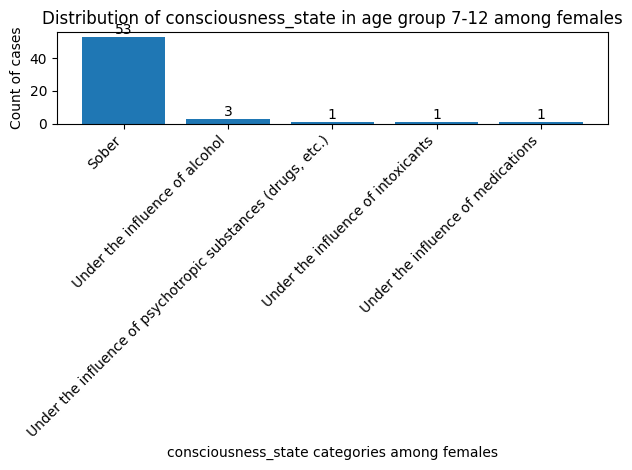

In [ ]:
create_bar_plot(
                male_serie_indexes,
                male_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [ ]:
male_probabilities = [x / sum(male_serie_values) for x in male_serie_values]

In [ ]:
male_null_index = male_index[data_age_group.loc[male_index, variable].isnull()]


In [ ]:
data_age_group.loc[male_null_index, variable] = np.random.choice(male_serie_indexes, size=len(male_null_index.tolist()), p=male_probabilities)

##### Summary

In [ ]:
new_female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

<ipython-input-411-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-411-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


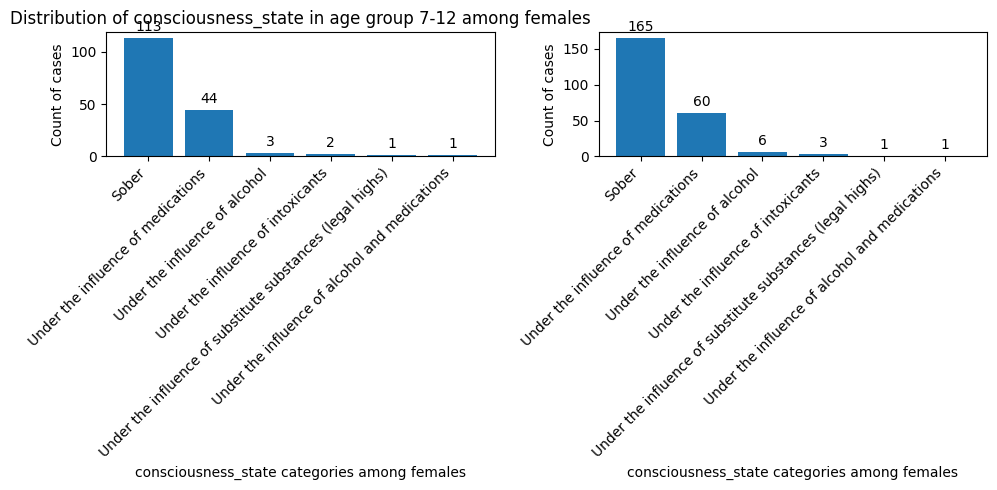

In [ ]:
create_double_bar_plot(
                      female_serie_indexes,
                      female_serie_values,
                      new_female_serie_values,
                      variable + ' categories' + ' among females',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                      x_rotation=45)

In [ ]:
new_male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

<ipython-input-411-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-411-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


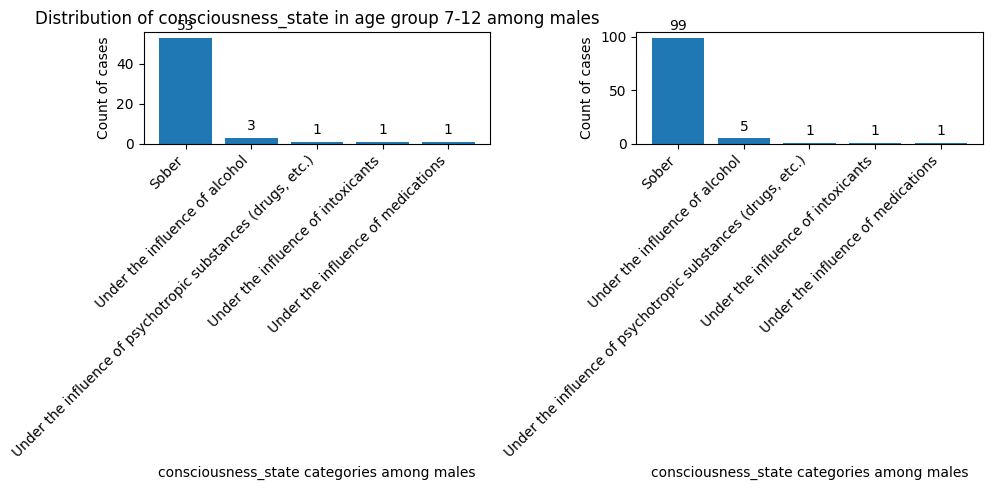

In [ ]:
create_double_bar_plot(
                      male_serie_indexes,
                      male_serie_values,
                      new_male_serie_values,
                      variable + ' categories' + ' among males',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                      x_rotation=45)

In [ ]:
new_serie_values = data_age_group[variable].value_counts().values.tolist()

<ipython-input-411-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-411-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


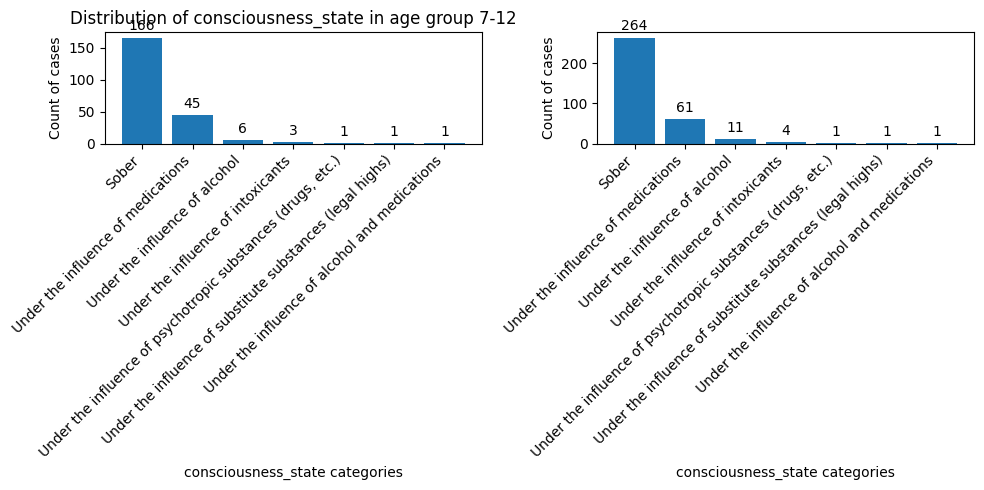

In [ ]:
create_double_bar_plot(
                serie_indexes,
                serie_values,
                new_serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

####Variable - reason_of_attack_count

In [464]:
variable = 'reason_of_attack_count'

In [465]:
display_info(data_age_group, [variable])

['reason_of_attack_count']
1

Mode:
0    1.0
Name: reason_of_attack_count, dtype: float64

NaN count: 85

Unique values len:
4

Unique values:
[ 1. nan  2.  3.]

Value counts:
1.0    204
2.0     49
3.0      5
Name: reason_of_attack_count, dtype: int64



In [466]:
serie_values = data_age_group[variable].dropna().value_counts().values.tolist()

In [467]:
serie_indexes = data_age_group[variable].dropna().value_counts().index.tolist()

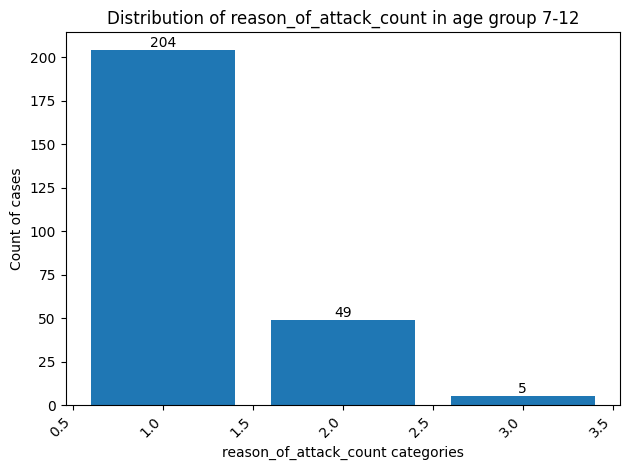

In [468]:
create_bar_plot(
                serie_indexes,
                serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####female

In [469]:
female_serie_indexes = data_age_group.loc[female_index, variable].dropna().value_counts().index.tolist()

In [470]:
female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

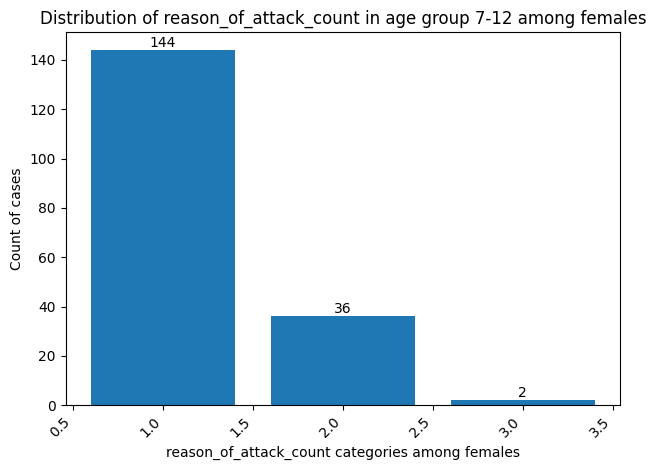

In [471]:
create_bar_plot(
                female_serie_indexes,
                female_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [472]:
female_probabilities = [x / sum(female_serie_values) for x in female_serie_values]

In [473]:
female_null_index = female_index[data_age_group.loc[female_index, variable].isnull()]


In [474]:
data_age_group.loc[female_null_index, variable] = np.random.choice(female_serie_indexes, size=len(female_null_index.tolist()), p=female_probabilities)

#####male

In [475]:
male_serie_indexes = data_age_group.loc[male_index, variable].dropna().value_counts().index.tolist()

In [476]:
male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

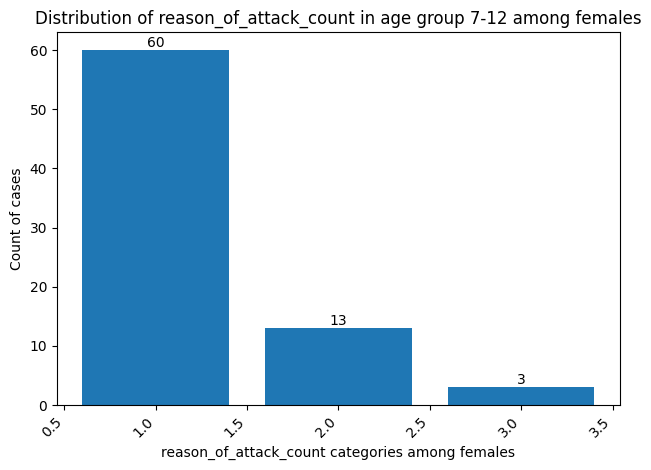

In [477]:
create_bar_plot(
                male_serie_indexes,
                male_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [478]:
male_probabilities = [x / sum(male_serie_values) for x in male_serie_values]

In [479]:
male_null_index = male_index[data_age_group.loc[male_index, variable].isnull()]


In [480]:
data_age_group.loc[male_null_index, variable] = np.random.choice(male_serie_indexes, size=len(male_null_index.tolist()), p=male_probabilities)

##### Summary

In [481]:
new_female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

<ipython-input-411-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-411-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


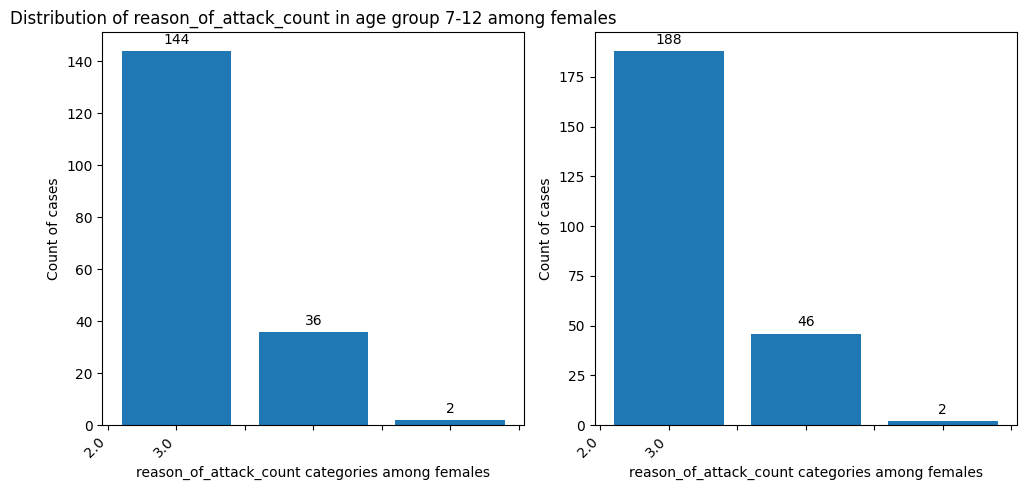

In [482]:
create_double_bar_plot(
                      female_serie_indexes,
                      female_serie_values,
                      new_female_serie_values,
                      variable + ' categories' + ' among females',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                      x_rotation=45)

In [483]:
new_male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

<ipython-input-411-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-411-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


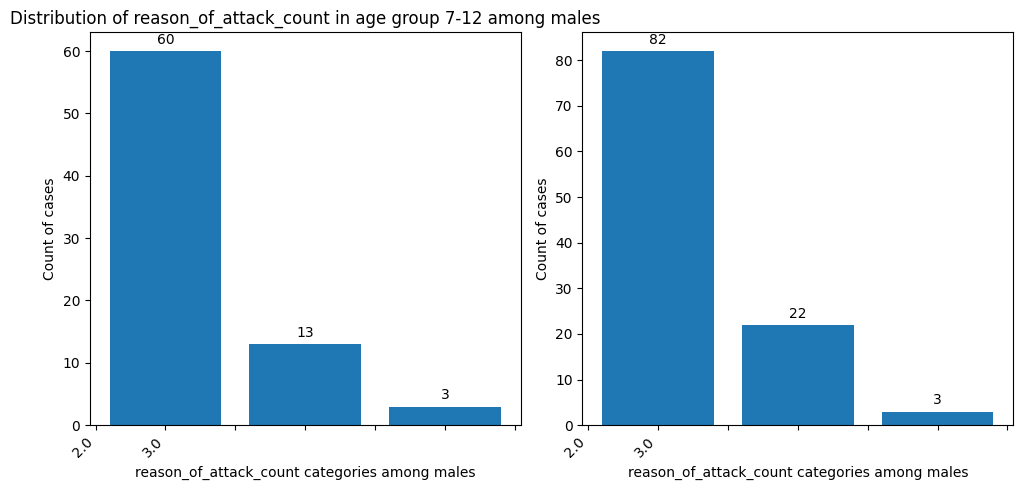

In [484]:
create_double_bar_plot(
                      male_serie_indexes,
                      male_serie_values,
                      new_male_serie_values,
                      variable + ' categories' + ' among males',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                      x_rotation=45)

In [485]:
new_serie_values = data_age_group[variable].value_counts().values.tolist()

<ipython-input-411-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-411-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


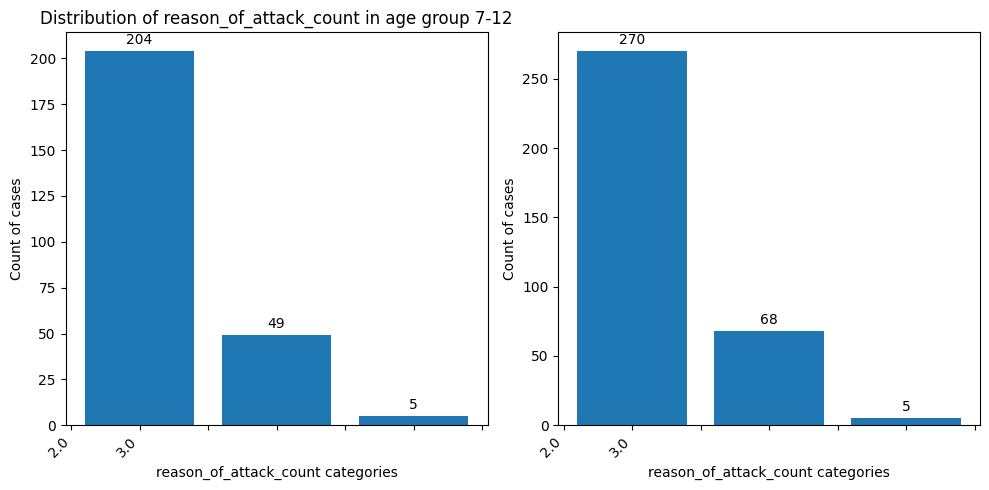

In [486]:
create_double_bar_plot(
                serie_indexes,
                serie_values,
                new_serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

##### data_age_group_7_12_reasons_of_attack

In [487]:
serie_indexes = data_age_group_reasons_of_attack.columns.tolist()

In [488]:
serie_values = data_age_group_reasons_of_attack[selected_columns].sum().tolist()

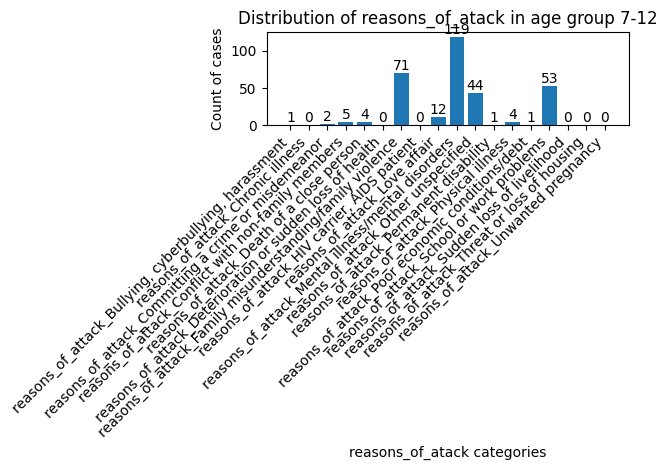

In [489]:
create_bar_plot(
                serie_indexes,
                serie_values,
                'reasons_of_atack' + ' categories',
                'Count of cases',
                'Distribution of ' + 'reasons_of_atack' + ' in age group ' + age_group,
                x_rotation=45)

###### female

In [490]:
female_series = data_age_group_reasons_of_attack.loc[female_index, serie_indexes].sum().tolist()

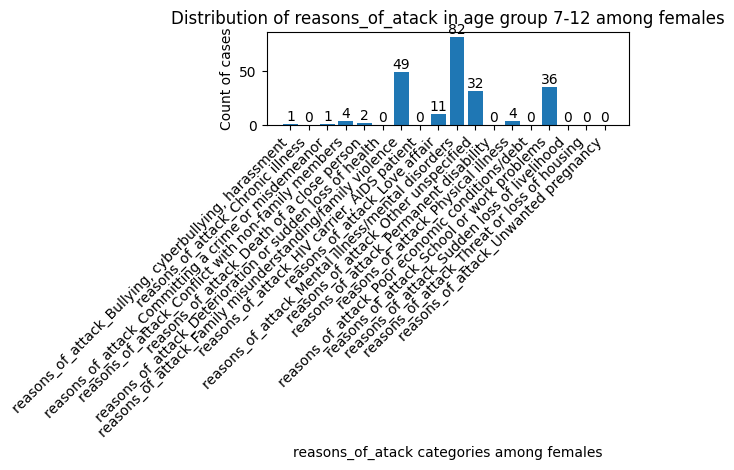

In [491]:
create_bar_plot(
                serie_indexes,
                female_series,
                'reasons_of_atack categories among females',
                'Count of cases',
                'Distribution of ' + 'reasons_of_atack' + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [492]:
female_probabilities = [x / sum(female_series) for x in female_series]

In [493]:
# Lista do przechowywania wylosowanych wartości dla każdej wartości w zmiennej
selected_values = []

# Iteracja przez wartości w zmiennej
for value in data_age_group.loc[female_null_index, variable]:
    # Losowanie wartości zgodnie z podanymi prawdopodobieństwami
    selected_value = np.random.choice(serie_indexes, size=int(value), p=female_probabilities)
    selected_values.append(selected_value)

In [494]:
# Iteracja przez indeksy i wartości w kolumnie reason_of_attack_count
for idx, selected_value in zip(female_null_index, selected_values):
    # Iteracja przez wylosowane wartości
    for column_name in selected_value:
        # Ustawienie wartości 1 w odpowiednich kolumnach
        data_age_group_reasons_of_attack.loc[idx, column_name] = 1


###### male

In [495]:
male_series = data_age_group_reasons_of_attack.loc[male_index, serie_indexes].sum().tolist()

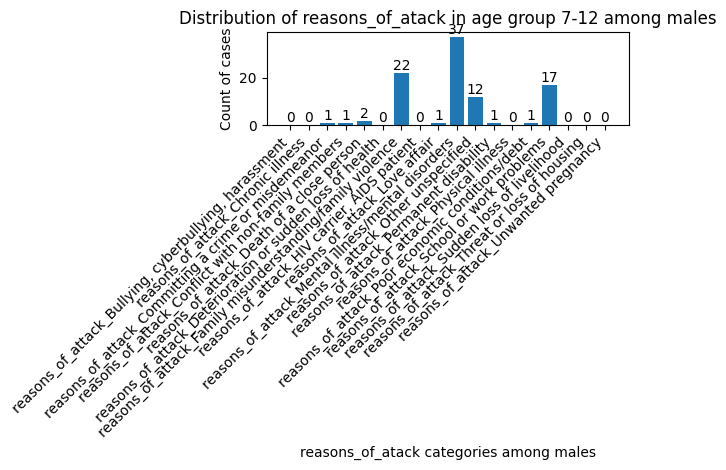

In [496]:
create_bar_plot(
                serie_indexes,
                male_series,
                'reasons_of_atack categories among males',
                'Count of cases',
                'Distribution of ' + 'reasons_of_atack' + ' in age group ' + age_group + ' among males',
                x_rotation=45)

In [497]:
male_probabilities = [x / sum(male_series) for x in male_series]

In [498]:
# Lista do przechowywania wylosowanych wartości dla każdej wartości w zmiennej
selected_values = []

# Iteracja przez wartości w zmiennej
for value in data_age_group.loc[male_null_index, variable]:
    # Losowanie wartości zgodnie z podanymi prawdopodobieństwami
    selected_value = np.random.choice(serie_indexes, size=int(value), p=male_probabilities)
    selected_values.append(selected_value)

In [499]:
# Iteracja przez indeksy i wartości w kolumnie reason_of_attack_count
for idx, selected_value in zip(male_null_index, selected_values):
    # Iteracja przez wylosowane wartości
    for column_name in selected_value:
        # Ustawienie wartości 1 w odpowiednich kolumnach
        data_age_group_reasons_of_attack.loc[idx, column_name] = 1


###### Summary

In [507]:
new_serie_values = data_age_group_reasons_of_attack[selected_columns].sum().tolist()

In [502]:
new_male_series = data_age_group_reasons_of_attack.loc[male_index, selected_columns].sum().tolist()

In [503]:
new_female_series = data_age_group_reasons_of_attack.loc[female_index, selected_columns].sum().tolist()

<ipython-input-411-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-411-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


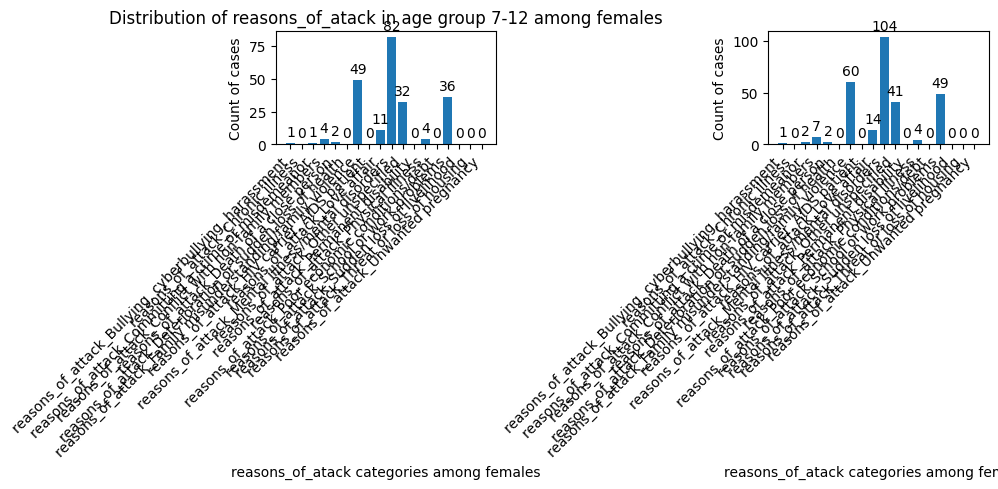

In [504]:
create_double_bar_plot(
                serie_indexes,
                female_series,
                new_female_series,
                'reasons_of_atack categories among females',
                'Count of cases',
                'Distribution of ' + 'reasons_of_atack' + ' in age group ' + age_group + ' among females',
                x_rotation=45)

<ipython-input-411-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-411-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


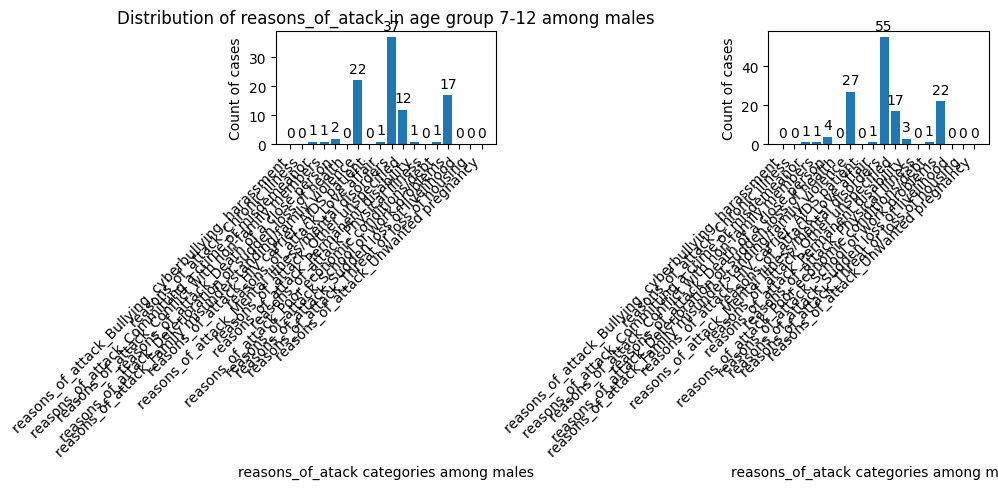

In [505]:
create_double_bar_plot(
                serie_indexes,
                male_series,
                new_male_series,
                'reasons_of_atack categories among males',
                'Count of cases',
                'Distribution of ' + 'reasons_of_atack' + ' in age group ' + age_group + ' among males',
                x_rotation=45)

<ipython-input-411-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-411-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


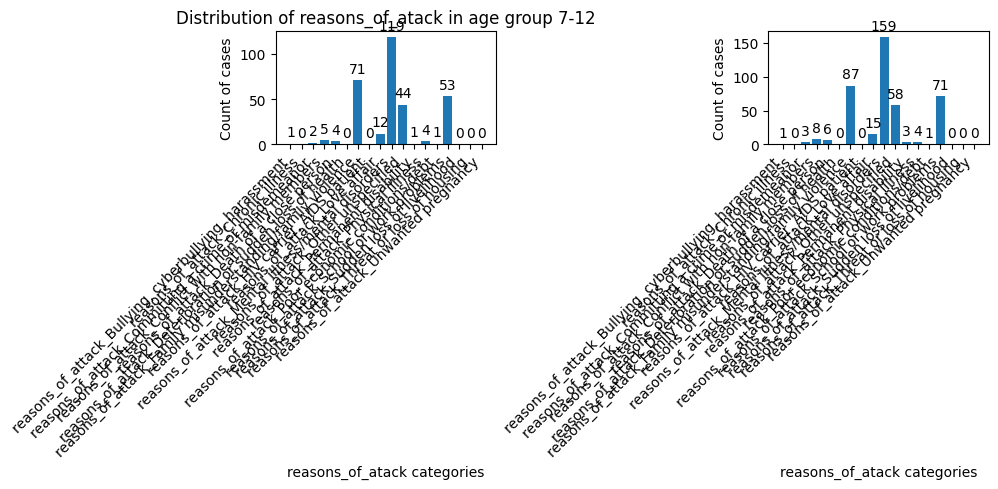

In [508]:
create_double_bar_plot(
                serie_indexes,
                serie_values,
                new_serie_values,
                'reasons_of_atack categories',
                'Count of cases',
                'Distribution of ' + 'reasons_of_atack' + ' in age group ' + age_group,
                x_rotation=45)